In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

dataset = pd.read_csv(filepath_or_buffer='pretreatmented_data.csv', header=None)
FEATURES_INDEX = np.arange(50)
LABELS_INDEX = 50
BATCH_SIZE = 50
LOSS_THRESHOLD = 1e-7
dataset.head()

spam_dataset = dataset[dataset[LABELS_INDEX] == 1]
nonspam_dataset = dataset[dataset[LABELS_INDEX] == 0]
nonspam_dataset.reset_index(drop=True, inplace=True)
spam_dataset.reset_index(drop=True, inplace=True)
nonspam_dataset.tail()

rand_indxs_spam = np.arange(len(spam_dataset))
rand_indxs_nonspam = np.arange(len(nonspam_dataset))
np.random.shuffle(rand_indxs_nonspam)
np.random.shuffle(rand_indxs_spam)

spam_f_threshold = int(len(spam_dataset)*0.6)
spam_s_threshold = int(len(spam_dataset)*0.9)

nonspam_f_threshold = int(len(nonspam_dataset)*0.6)
nonspam_s_threshold = int(len(nonspam_dataset)*0.9)

learn_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[:spam_f_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[:nonspam_f_threshold]]])

valid_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_f_threshold:spam_s_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_f_threshold:nonspam_s_threshold]]])

test_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_s_threshold:]],
                         nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_s_threshold:]]])

print(len(learn_dataset), len(valid_dataset), len(test_dataset), len(learn_dataset)+len(valid_dataset)+len(test_dataset), len(dataset))

In [2]:
FEATURES_INDEX = [0, 1]
LABELS_INDEX = 2
LOSS_THRESHOLD = 1e-6

In [3]:
learn_dataset = pd.read_csv('learn_data.csv', index_col=0)
valid_dataset = pd.read_csv('valid_data.csv', index_col=0)
test_dataset = pd.read_csv('test_data.csv', index_col=0)
learn_dataset.head()

,0,1,2
0,0.980200,-0.735111,-0.573921
1,-1.758554,0.527610,2.068426
2,0.066156,0.404232,-0.447753
3,0.919834,-0.836112,-0.615778
4,-0.676431,-0.458955,0.800171


In [4]:
learn_dataset = np.array(learn_dataset)
valid_dataset = np.array(valid_dataset)
test_dataset = np.array(test_dataset)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(2, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 5)
        self.lin4 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.tanh(self.lin1(x))
        x = F.tanh(self.lin2(x))
        x = F.tanh(self.lin3(x))
        x = self.lin4(x)
        return x

net = Net()
net

Net(
  (lin1): Linear(in_features=2, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=5, bias=True)
  (lin4): Linear(in_features=5, out_features=1, bias=True)
)

In [7]:
is_load = False
if is_load:
    net.load_state_dict(torch.load('minibatch/net_params.pkl'))

In [8]:
#Инициализация весов
STD = [(2/(2+10+1))**(1/2), (2/(10+10+1))**(1/2), (2/(10+5+1))**(1/2), (2/(5+1+1))**(1/2)]
null_weigth = []
STD.reverse()

def get_weights(layer):
    if (type(layer) == nn.Linear):
        cur_std = STD.pop()
        null_weigth.append(torch.randn(layer.weight.data.shape)*cur_std)
        null_weigth.append(torch.randn(layer.bias.data.shape)*cur_std)

net.apply(get_weights)
for k in null_weigth:
    print(k.shape)
print(null_weigth[1])
null_weigth.reverse()

torch.Size([10, 2])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([5, 10])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])
tensor([-0.1770, -0.5214,  0.5249,  0.4687,  0.1812,  0.4249, -0.0874,
        -0.6346, -0.4292, -1.0919])


In [9]:
tmp_null_weigth = list(null_weigth)

def init_weigths(layer):
    if(type(layer) == nn.Linear):
        layer.weight.data = (tmp_null_weigth.pop()).clone()
        layer.bias.data = (tmp_null_weigth.pop()).clone()
        
net.apply(init_weigths)
net.lin1.bias

Parameter containing:
tensor([-0.1770, -0.5214,  0.5249,  0.4687,  0.1812,  0.4249, -0.0874,
        -0.6346, -0.4292, -1.0919])

In [10]:
criterion = nn.MSELoss(size_average=True)
lr = 0.001

In [12]:
%%time
learn_loss_by_batch = []
valid_loss_by_batch = []
test_loss_by_batch = []
epoch_loss_by_batch = []
batch_list = [1, 20, 100, 250]
end_learn_loss_by_batch = []
end_test_loss_by_batch = []

for batch_size in batch_list:
    optimizer = optim.SGD(net.parameters(), lr=0.001)
    
    learn_dataloader = DataLoader(learn_dataset, batch_size=batch_size, shuffle=False)
    valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    
    tmp_null_weigth = list(null_weigth)
    net.apply(init_weigths)
    
    learn_epoch_loss = []
    valid_epoch_loss = []
    test_epoch_loss = []
    epoch_list = []
    
    for epoch in range(5*10**3):
        loss_acc = []
        for learn_data in learn_dataloader:
            optimizer.zero_grad()
            features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            features.requres_grad = True
            labels.requres_grad = True
            outputs = net(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_acc.append(float(loss.data))
        learn_epoch_loss.append(np.mean(loss_acc))
        
        #критерий останова
        if (epoch > 10) and\
        (abs(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2]) < LOSS_THRESHOLD):
            print(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2])
            print('batch: ', batch_size, ' breaked on epoch: ', epoch, '\n')
            break
            
        if epoch % 10 == 0:
            epoch_list.append(epoch)
            for valid_data in valid_dataloader:
                features, labels = valid_data[:, FEATURES_INDEX].float(), valid_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                valid_epoch_loss.append(float(loss.data))
                
            for test_data in valid_dataloader:
                features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                test_epoch_loss.append(float(loss.data))
                
    learn_loss_by_batch.append(learn_epoch_loss)
    valid_loss_by_batch.append(valid_epoch_loss)
    test_loss_by_batch.append(test_epoch_loss)
    epoch_loss_by_batch.append(epoch_list)
    end_learn_loss_by_batch.append(learn_epoch_loss[-1])
    end_test_loss_by_batch.append(test_epoch_loss[-1])

-9.995809899937536e-07
batch:  1  breaked on epoch:  1796 

-9.961330737773277e-07
batch:  20  breaked on epoch:  836 

-9.904516504177785e-07
batch:  100  breaked on epoch:  2697 

CPU times: user 53min 24s, sys: 1min 38s, total: 55min 3s
Wall time: 48min 50s


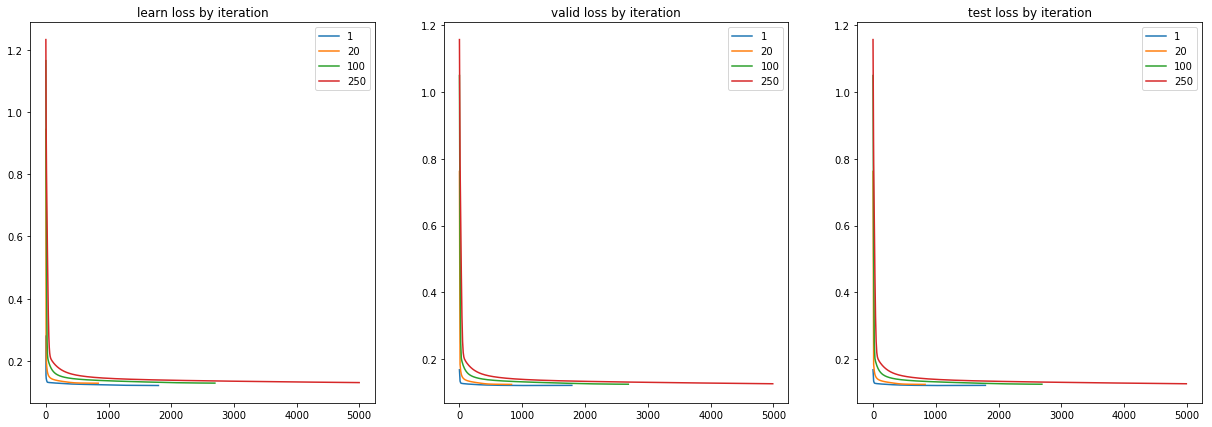

In [13]:
#learn
plt.figure(figsize=(21, 7))
plt.subplot(1, 3, 1)
for num, batch in enumerate(batch_list):
    plt.plot(learn_loss_by_batch[num], label=str(batch))
plt.title('learn loss by iteration')
plt.legend()

#valid
plt.subplot(1, 3, 2)
for num, batch in enumerate(batch_list):
    plt.plot(epoch_loss_by_batch[num], valid_loss_by_batch[num], label=str(batch))
plt.title('valid loss by iteration')
plt.legend()

plt.subplot(1, 3, 3)
for num, i in enumerate(batch_list):
    plt.plot(epoch_loss_by_batch[num], test_loss_by_batch[num], label=str(i))
plt.title('test loss by iteration')
plt.legend()

plt.savefig('nikminibatch_lossss.png', bbox_inches='tight')

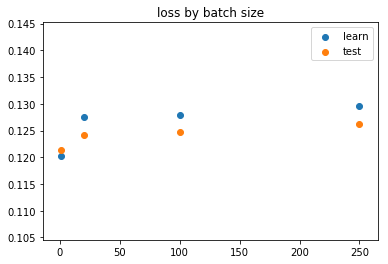

In [14]:
plt.scatter(batch_list, end_learn_loss_by_batch, label='learn')
plt.scatter(batch_list, end_test_loss_by_batch, label='test')
plt.legend()
plt.title('loss by batch size')
plt.savefig('nikminibatch_end_loss.png', bbox_inches='tight')

In [ ]:
for batchloss in end_learn_loss_by_batch:
    print(batchloss)
print('\n')
for batchloss in end_test_loss_by_batch:
    print(batchloss)